In [1]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

data_dir = tf.keras.utils.get_file(
    origin='https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/t6j2h22jpx-1.zip',
    fname='plant_photos', untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*/*.jpg')))
image_count
# CLASS_NAMES = ['APPLE', 'PEAR', 'CHERRY', 'GRAPES', 'APRICOT', 'CRANBERRY', 'WALNUT', 'PEACH']
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['APPLE', 'PEAR', 'CHERRY', 'GRAPES', 'APRICOT', 'CRANBERRY',
       'WALNUT', 'PEACH'], dtype='<U9')

Ik begin met het importeren van tensorflow en de benodigde dataset

In [18]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

apples = list(data_dir.glob('APPLES/HEALTHY/*'))

for image_path in apples[:3]:
    display.display(Image.open(str(image_path)))

# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))


Found 2153 images belonging to 8 classes.


b'/Users/farah/.keras/datasets/plant_photos/PEACH/HEALTHY/peach_h226.JPG'
b'/Users/farah/.keras/datasets/plant_photos/PEACH/HEALTHY/peach_h099.JPG'
b'/Users/farah/.keras/datasets/plant_photos/PEACH/HEALTHY/peach_h063.JPG'
b'/Users/farah/.keras/datasets/plant_photos/APRICOT/DISEASED/apricot_d107.JPG'
b'/Users/farah/.keras/datasets/plant_photos/APPLE/DISEASED/apple_d126.JPG'


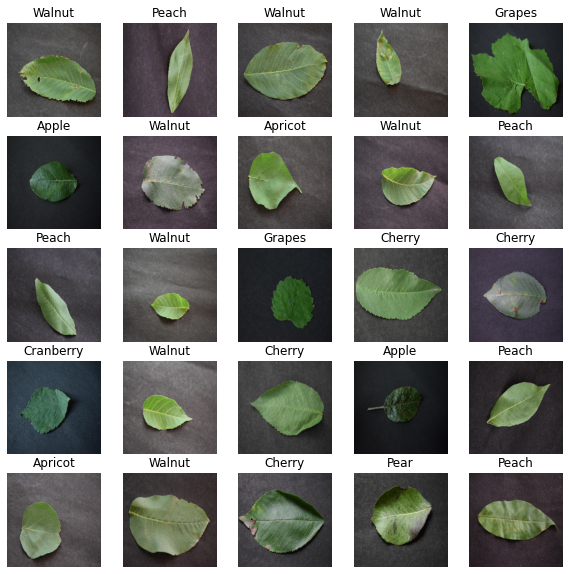

In [3]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        try:
            plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        except:
            plt.title('test')
        plt.axis('off')


image_batch, label_batch = next(train_data_gen)

saved_label = label_batch
show_batch(image_batch, label_batch)

list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*/*'))

for f in list_ds.take(5):
    print(f.numpy())

In [11]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False]


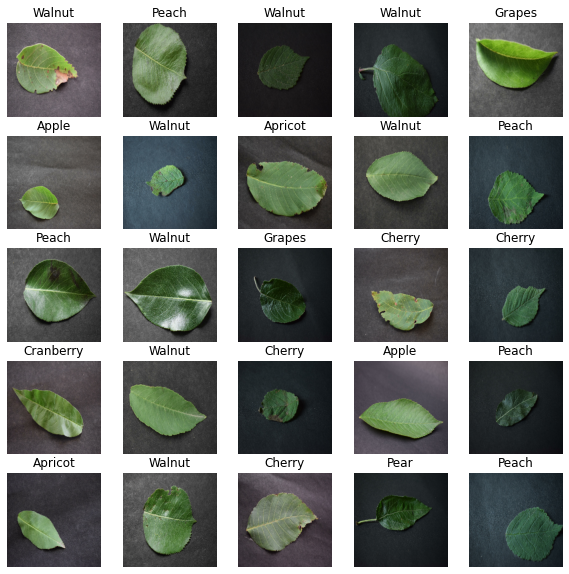

In [12]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


def prepare_for_training(ds, cache=True, shuffle_buffer_size=10):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

# print(image_batch)
# print('-----')
# print(label_batch.numpy())

show_batch(image_batch.numpy(), saved_label)

In [13]:
import time

default_timeit_steps = 10
def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i % 10 == 0:
            print('.', end='')
    print()
    end = time.time()

    duration = end - start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))


# `keras.preprocessing`
timeit(train_data_gen)

# `tf.data`
timeit(train_ds)

uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

filecache_ds = prepare_for_training(labeled_ds, cache="./plants.tfcache")
# timeit(filecache_ds)


.
10 batches: 147.91795825958252 s
2.16336 Images/s
.
10 batches: 119.08599376678467 s
2.68713 Images/s
.
10 batches: 113.05312585830688 s
2.83053 Images/s


In [44]:
from tensorflow import keras

batch_size = 32
epochs = 10

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
model.fit(image_batch, label_batch, epochs=epochs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 19,269,002
Trainable params: 19,269,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4978 - accuracy: 0.8248
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3767 - accuracy: 0.8637
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3397 - accuracy: 0.8759
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/ste